## Lab 1: Digital Sampling, Fourier Filtering, and Heterodyne Mixers
Name: Kaitlyn Le

Date: February 6, 2026

Astro 121

# Environment Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
from src import plotting_stuff, analysis

plotting_stuff.setup_plot_style()

## Abstract

The question we want to answer is what are the fundamental mathematical and physical limitations of digitalizing analog radio signals? We explore the fundamentals of digital signal processing and radio reception: the Nyquist-Shannon sampling theorem, the statistical properties of thermal noise, and heterodyne mixing. By sampling a 1 MHz sinusoidal reference signal at rates ranging from 1.0 to 3.0 MHz, we quantitatively verified the effects of aliasing, observing that signals fold back into the first Nyquist zone as predicted by theory. By testing the Nyquist criterion, we can then determine the minimum speed required to capture a signal without corruption, which is the aliasing phenomenon. We further analyzed a laboratory noise source, confirming it follows a Gaussian voltage distribution and that the radiometer equation holds, with noise scaling as $1/\sqrt{N}$ when averaging $N$ blocks. Characterizing the random interference would set the lower limit of the sensitivity of capturing data, which contributes to answering the question. Finally, we constructed a software-defined heterodyne mixer to isolate specific sidebands from an RF signal, which then shows how we can preserve the full information of a wave using complex signal processing.

# Introduction
Radio astronomy relies on converting high-frequency analog signals into digital data streams for computational analysis. 

## Fourier Analysis (DFT and FFT)
Time-domain voltage data $V(t)$ then has to be converted into a frequency-domain power spectrum $P(f)$ after digitizing the signal. 
We utilized the Fast Fourier Transform (FFT), which reduces the computational complexity from $O(N^2)$ to $O(N \log N)$. The reason we use this method is that it computes large datasets on a much lower scale than the Discrete Fourier Transform method. We will use both of these transforms to visualize 
aliasing and noise properties.

## Digital Sampling and the Nyquist Criterion
The Nyquist-Shannon sampling theorem exhibits that to perfectly reconstruct a signal of bandwidth $B$, we must sample at a rate $f_s > 2B$. Failure to do so results in aliasing, where high-frequency signals fold into lower frequencies. This leads to false detections.

## Heterodyne Mixing
Radio wave frequencies are profoundly high, which causes an inability to directly digitize these samples. To bypass the problem of not being able to directly sample these waves, receivers use heterodyne mixing, where incoming Radio Frequency (RF) is multiplied by a Local Oscillator (LO) signal. This shifts the information to a lower "baseband" or Intermediate Frequency (IF). A key challenge in mixing is spectral leakage: simple "real-valued" mixing causes upper and lower sidebands to mirror and overlap (Double Sideband). This report will discuss how complex ($I/Q$) mixing solves this issue by preserving wave information, allowing for Single Sideband (SSB) isolation.

## Working Question
*What are the fundamental mathematical and physical limitations of digitalizing analog radio signals?*

In §2 we review the mathematical theory. In §3 we present results on Nyquist aliasing along with spectral leakage analysis. In §4 we characterize the thermal noise of our system. In §5 we compare real vs. complex mixing schemes, and we conclude in §6.

# Background

## The Nyquist-Shannon Sampling Theorem
Digitalizing an analog signal $V(t)$ measures the voltage at discrete time intervals $t_n = n/f_s$, where $f_s$ is the sampling rate. The Nyquist-Shannon Sampling Theorem states that a continuous signal with a maximum frequency bandwidth $B$ can be perfectly reconstructed if and only if:
$$f_s > 2B$$
The frequency $f_{Nyq} = f_s/2$ is known as the Nyquist Frequency/Criterion.

## Aliasing
If a signal's frequency violates the Nyquist Criterion by exceeding the threshold, the sampler cannot distinguish it from a lower frequency signal. This is known as aliasing. The higher frequency folds into the first Nyquist zone ($0$ to $f_s/2$). The observed frequency $f_{obs}$ is given by:
$$f_{obs} = | f_{sig} - N \cdot f_s |$$
where $N$ is the integer that minimizes the difference. 
## The Discrete Fourier Transform (DFT)
The Fourier Transform is defined as:
$\hat{f}(\omega) = \int_{-\infty }^{\infty}f(t)e^{i\omega t}dt$. 
This equation analyzes the signal in the time and frequency domains. It decomposes a signal into Fourier components. However, the analysis cannot be used with digitally sampled data since there are discretely sampled points. Thus, a summation is necessary to analyze the signal rather than an integral, which can be used with the Discrete Fourier Transform. 
When we sample at a finite rate and time window, the integral becomes the summation: 
$\hat{f}(\omega) = \frac{1}{N\Delta t} \sum\limits_{n=1}^{N}f_{n}e^{j\omega n \Delta t}\Delta t$

where N $=$ total number of data points sampled and $ \Delta t$ is the time interval between samples. 

The power spectrum $P[k]$, which corresponds to the physical power measured by the receiver, is the squared magnitude of the DFT:
$$P[\omega] = |\hat{}f(\omega)|^2$$
## Noise Statistics
Signals are buried in thermal noise generated by the receiver electronics and the sky background. This noise is generated randomly; individual voltage samples $V$ follow a Gaussian (Normal) Distribution:
$$P(V) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(V - \mu)^2}{2\sigma^2}}$$
where $\mu$ is the mean voltage and $\sigma$ is the standard deviation, representing the noise power ($P_{noise} \propto \sigma^2$).

## Heterodyne Mixing
Receivers cannot directly digitize high-frequency RF signals (e.g., 1420 MHz). Thus, mixers can be used to shift the signal to a lower Intermediate Frequency (IF). A mixer multiplies the Radio Frequency ($V_{RF}$) by a Local Oscillator ($V_{LO}$):
$$V_{mix}(t) = V_{RF}(t) \times V_{LO}(t)$$
Using the trigonometric identity $\cos(A)\cos(B) = \frac{1}{2}[\cos(A-B) + \cos(A+B)]$, mixing two sinusoids at frequencies $f_{RF}$ and $f_{LO}$ produces two output frequencies: Sum (Up-conversion) where $f_{RF} + f_{LO}$  and Difference (Down-conversion): $|f_{RF} - f_{LO}|$. The "up-conversion" is usually filtered out while the "down-conversion" is the desired IF.

## Real vs. Complex Mixing
In a "Real" mixer, which multiplies two real numbers, the information at $f_{LO} + \Delta f$ (Upper Sideband) and $f_{LO} - \Delta f$ (Lower Sideband) maps to the same intermediate frequency $\Delta f$. However, with real mixers, the sidebands become identical. Complex Mixing (or I/Q Mixing) is when we sample the signal with two mixers phase-shifted by $90^\circ$ (generating In-phase $I$ and Quadrature $Q$ components). We can effectively multiply the signal by a complex exponential $e^{-i\omega_{LO}t}$. This preserves the phase relationship, allowing us to identify positive frequencies (Upper Sideband) from negative frequencies (Lower Sideband) in the Fourier domain.

# Experiment One: Nyquist Sampling

## Objective
The objective of this experiment was to empirically verify the Nyquist-Shannon sampling theorem. We aimed to demonstrate that when the sampling rate $f_s$ falls below twice the signal frequency ($2f_{sig}$), the signal does not disappear but instead aliases to a predictable frequency in the baseband.By testing the theorem, we can then determine the minimum speed required to capture a signal without corruption.

## Experimental Setup
We utilized a waveform generator connected via coaxial cable to the RTL-SDR dongle. The SDR is in direct sampling mode for this experiment, meaning that we are bypassing the anti-aliasing filters.
* Signal: A sine wave was generated at a constant frequency of 1.0 MHz.
* Data Collection: We captured time-domain voltage data at five distinct sampling rates: 1.0, 1.5, 2.0, 2.5, and 3.0 MHz.
* Software: Data was acquired using the `ugradio` Python interface, capturing 2048 samples per trial.

## Analysis
For each dataset, we computed the Power Spectral Density (PSD) using the Fast Fourier Transform (FFT). We identified the peak frequency in the spectrum and compared it to the theoretical aliasing prediction:
$$f_{expected} = | 1.0 \text{ MHz} - N \cdot f_s |$$

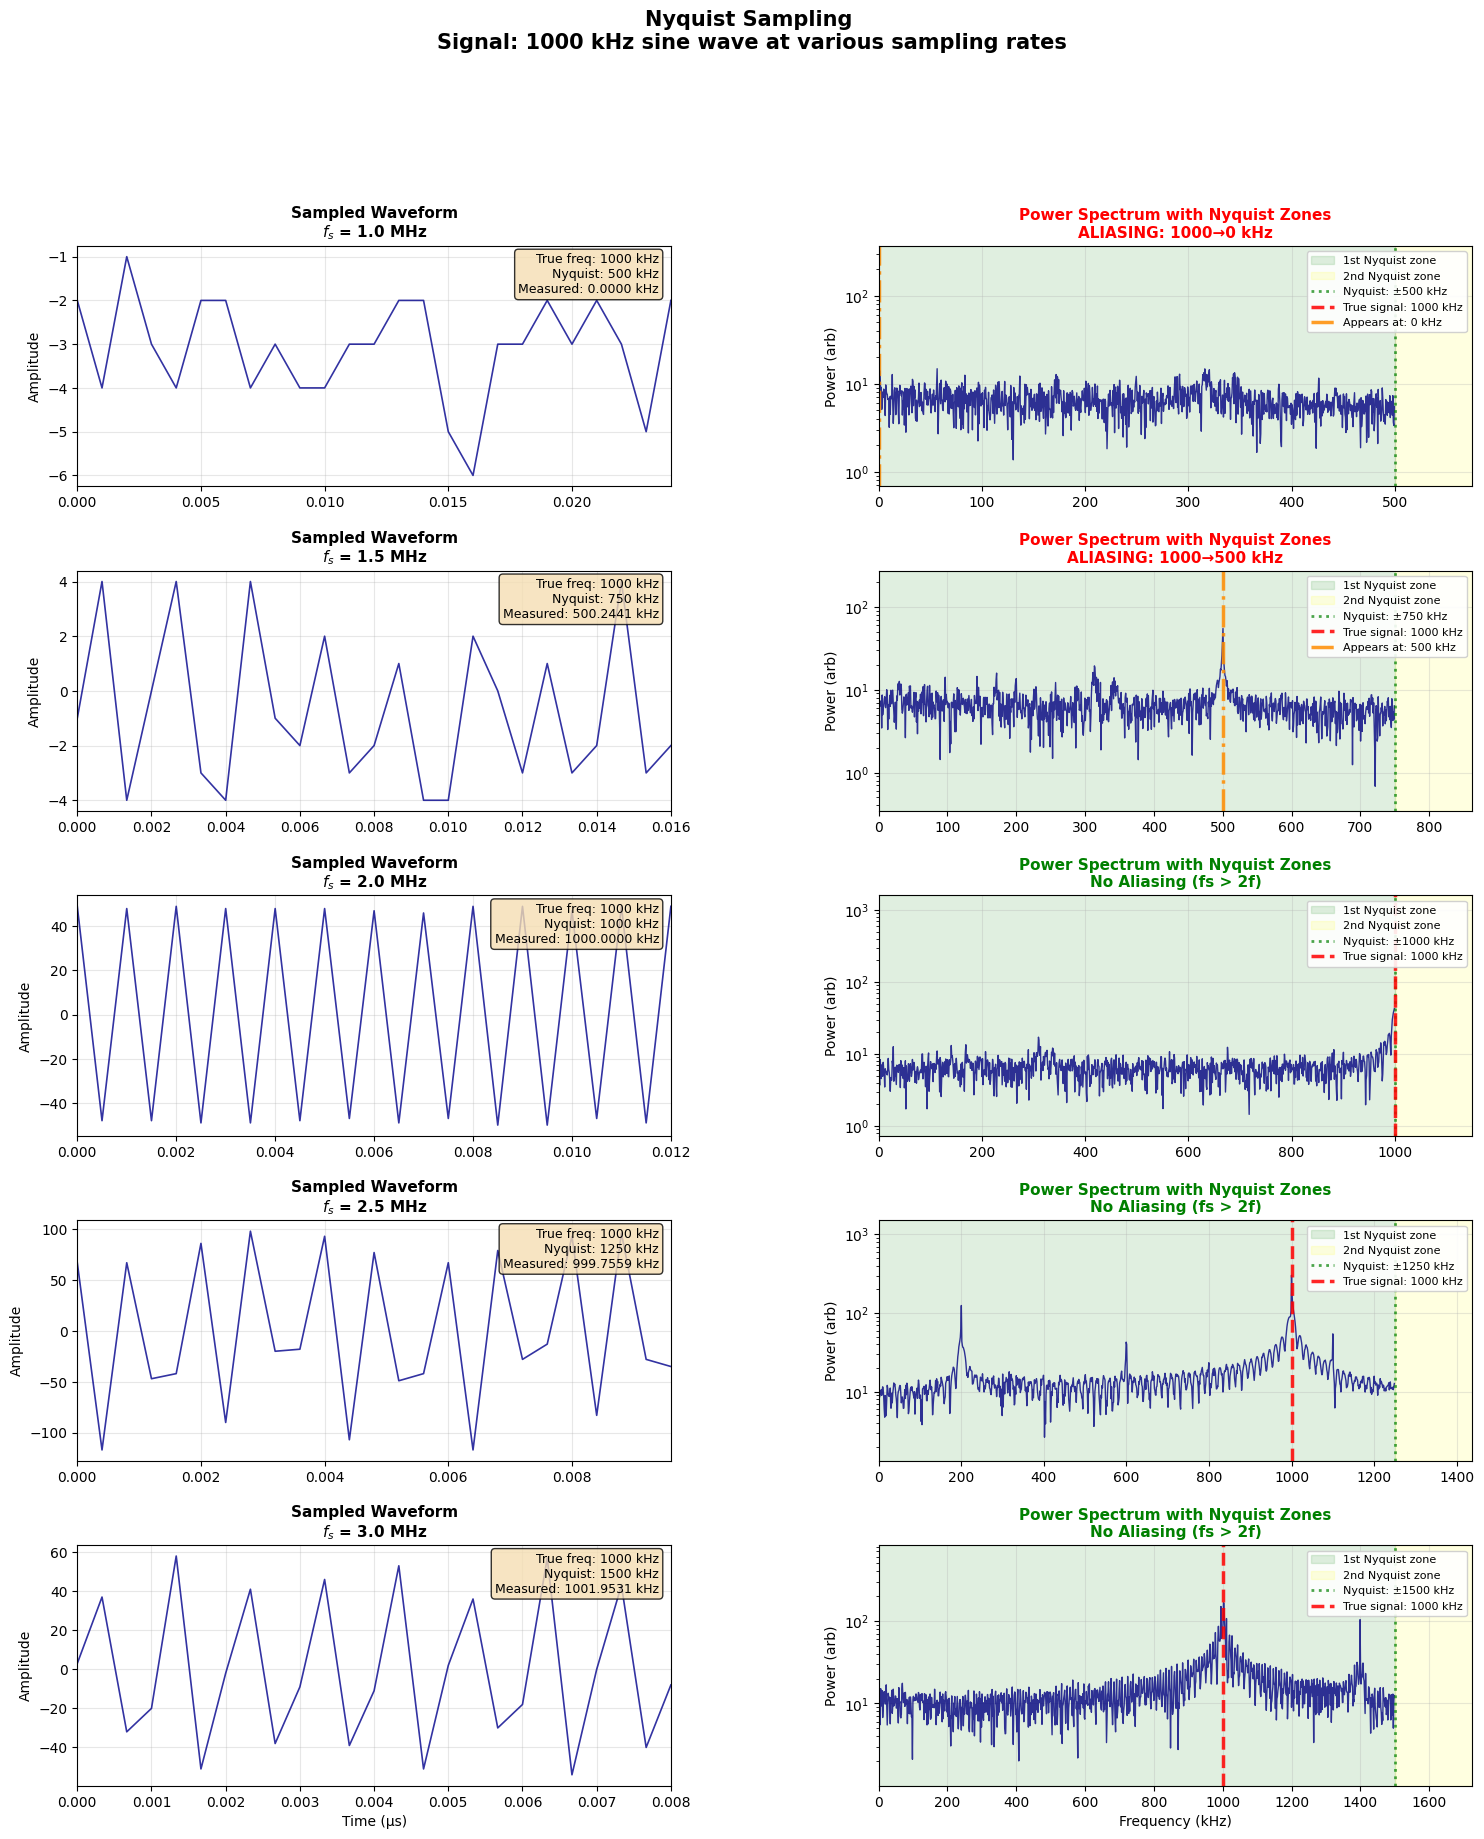

In [9]:
#loading data
nyquist_files = [r"C:\Users\kaitl\radio_stars\Astro-121-Radio-Stars\lab1\sinewave_test\sine_wave_1e6_rf\bypassed_f1p000e06_sr1p000e06_20260205_002825.npz",
                 r"C:\Users\kaitl\radio_stars\Astro-121-Radio-Stars\lab1\sinewave_test\sine_wave_1e6_rf\bypassed_f1p000e06_sr1p500e06_20260205_002827.npz",
                 r"C:\Users\kaitl\radio_stars\Astro-121-Radio-Stars\lab1\sinewave_test\sine_wave_1e6_rf\bypassed_f1p000e06_sr2p000e06_20260205_002829.npz",
                 r"C:\Users\kaitl\radio_stars\Astro-121-Radio-Stars\lab1\sinewave_test\sine_wave_1e6_rf\bypassed_f1p000e06_sr2p500e06_20260205_002831.npz",
                 r"C:\Users\kaitl\radio_stars\Astro-121-Radio-Stars\lab1\sinewave_test\sine_wave_1e6_rf\bypassed_f1p000e06_sr3p000e06_20260205_002832.npz",
                ]
nyquist_data = {}
for file in nyquist_files:
    loaded = np.load(file)
    sr = loaded['sample_rate']
    data = loaded['data']     
    if data.ndim > 1:
        data = data.squeeze() 
        
    if data.ndim > 1:
        data = data[0]
    
    nyquist_data[file] = {
        'data': data,
        'signal_freq': loaded['signal_freq'],
        'sample_rate': sr
    }

n_datasets = len(nyquist_data)
fig = plt.figure(figsize=(18, 4*n_datasets))
gs = fig.add_gridspec(n_datasets, 2, hspace=0.35, wspace=0.35)

for row_idx, (file, ds) in enumerate(nyquist_data.items()):
    data = ds['data']
    signal_freq = ds['signal_freq']
    sr = ds['sample_rate']
    nyquist = sr / 2
    
    if data.ndim > 1:
        data = data.flatten()
    
    # Compute power spectrum
    try:
        freqs, power = analysis.compute_power_spectrum(data, sr, method='fft')
        
        # peak 
        peak_idx = np.argmax(power)
        measured_freq = abs(freqs[peak_idx])
        
    except Exception as e:
        raise

    # Determine if aliasing occurs
    is_aliasing = signal_freq > nyquist
    if is_aliasing:
        aliased_freq = sr - signal_freq
        status = f"ALIASING: {signal_freq/1e3:.0f}→{aliased_freq/1e3:.0f} kHz"
        status_color = 'red'
    else:
        status = "No Aliasing (fs > 2f)"
        status_color = 'green'
    
#time series data
    ax_time = fig.add_subplot(gs[row_idx, 0])
    
    t = np.arange(len(data)) / sr * 1e3  # microseconds
    n_display = min(25, len(data))
    ax_time.plot(t[:n_display], data[:n_display], 
                linewidth=1.2, color='darkblue', alpha=0.8)
    
    ax_time.set_ylabel('Amplitude', fontsize=10)
    ax_time.grid(True, alpha=0.3)
    ax_time.set_xlim([0, t[n_display-1]])
    ax_time.set_title(f'Sampled Waveform\n$f_s$ = {sr/1e6:.1f} MHz', 
                     fontsize=11, fontweight='bold')
    
    info_text = (f'True freq: {signal_freq/1e3:.0f} kHz\n'
                f'Nyquist: {nyquist/1e3:.0f} kHz\n'
                f'Measured: {measured_freq/1e3:.4f} kHz')
    ax_time.text(0.98, 0.97, info_text,
                transform=ax_time.transAxes,
                fontsize=9, verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    if row_idx == n_datasets - 1:
        ax_time.set_xlabel('Time (μs)', fontsize=10)
    
#Power Spectrum with Nyquist Zones 
    ax_spec = fig.add_subplot(gs[row_idx, 1])
    
    ax_spec.semilogy(freqs/1e3, power, linewidth=1, color='navy', alpha=0.8)
    
    # Shade Nyquist zones
    ax_spec.axvspan(-nyquist/1e3, nyquist/1e3, alpha=0.12, color='green',
                   label='1st Nyquist zone', zorder=0)
    ax_spec.axvspan(nyquist/1e3, sr/1e3, alpha=0.12, color='yellow',
                   label='2nd Nyquist zone', zorder=0)
    ax_spec.axvspan(-sr/1e3, -nyquist/1e3, alpha=0.12, color='yellow', zorder=0)
    
    # Draw boundaries
    ax_spec.axvline(nyquist/1e3, color='green', linestyle=':', 
                   linewidth=2, alpha=0.7, label=f'Nyquist: ±{nyquist/1e3:.0f} kHz')
    ax_spec.axvline(-nyquist/1e3, color='green', linestyle=':', 
                   linewidth=2, alpha=0.7)
    
    # Mark frequencies
    ax_spec.axvline(signal_freq/1e3, color='red', linestyle='--', 
                   linewidth=2.5, alpha=0.85,
                   label=f'True signal: {signal_freq/1e3:.0f} kHz')
    
    if is_aliasing:
        ax_spec.axvline(aliased_freq/1e3, color='darkorange', linestyle='-.', 
                       linewidth=2.5, alpha=0.85,
                       label=f'Appears at: {aliased_freq/1e3:.0f} kHz')
    
    ax_spec.set_ylabel('Power (arb)', fontsize=10)
    ax_spec.set_title(f'Power Spectrum with Nyquist Zones\n{status}', 
                     fontsize=11, fontweight='bold', color=status_color)
    ax_spec.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax_spec.grid(True, alpha=0.3)
    ax_spec.set_xlim([0, sr/2/1e3*1.15])
    
    power_positive = power[power > 0]
    if len(power_positive) > 0:
        ax_spec.set_ylim([power_positive.min() * 0.5, power.max() * 5])
    
    if row_idx == n_datasets - 1:
        ax_spec.set_xlabel('Frequency (kHz)', fontsize=10)

fig.suptitle('Nyquist Sampling \n'
             f'Signal: {signal_freq/1e3:.0f} kHz sine wave at various sampling rates', 
             fontsize=15, fontweight='bold', y=0.998)

plt.show()

Figure 1: The left column displays voltage spectra of a 1000 kHz (or 1.0 MHz) sine wave with sampling rates from 1.0 to 3.0 MHz. The right column shows power spectra of the same parameters. Green zones represent the Nyquist bandwidth (0 to fs/2), while yellow zones show where frequencies alias. At 1.5 MHz (second panel), the signal undersamples and folds back to 500 kHz, confirming the aliasing prediction. The higher sampling rates (2.5 and 3.0 MHz) show the signal correctly at 1000 kHz, though spectral leakage is visible as widened "skirts" around the main peak due to the finite recording window.

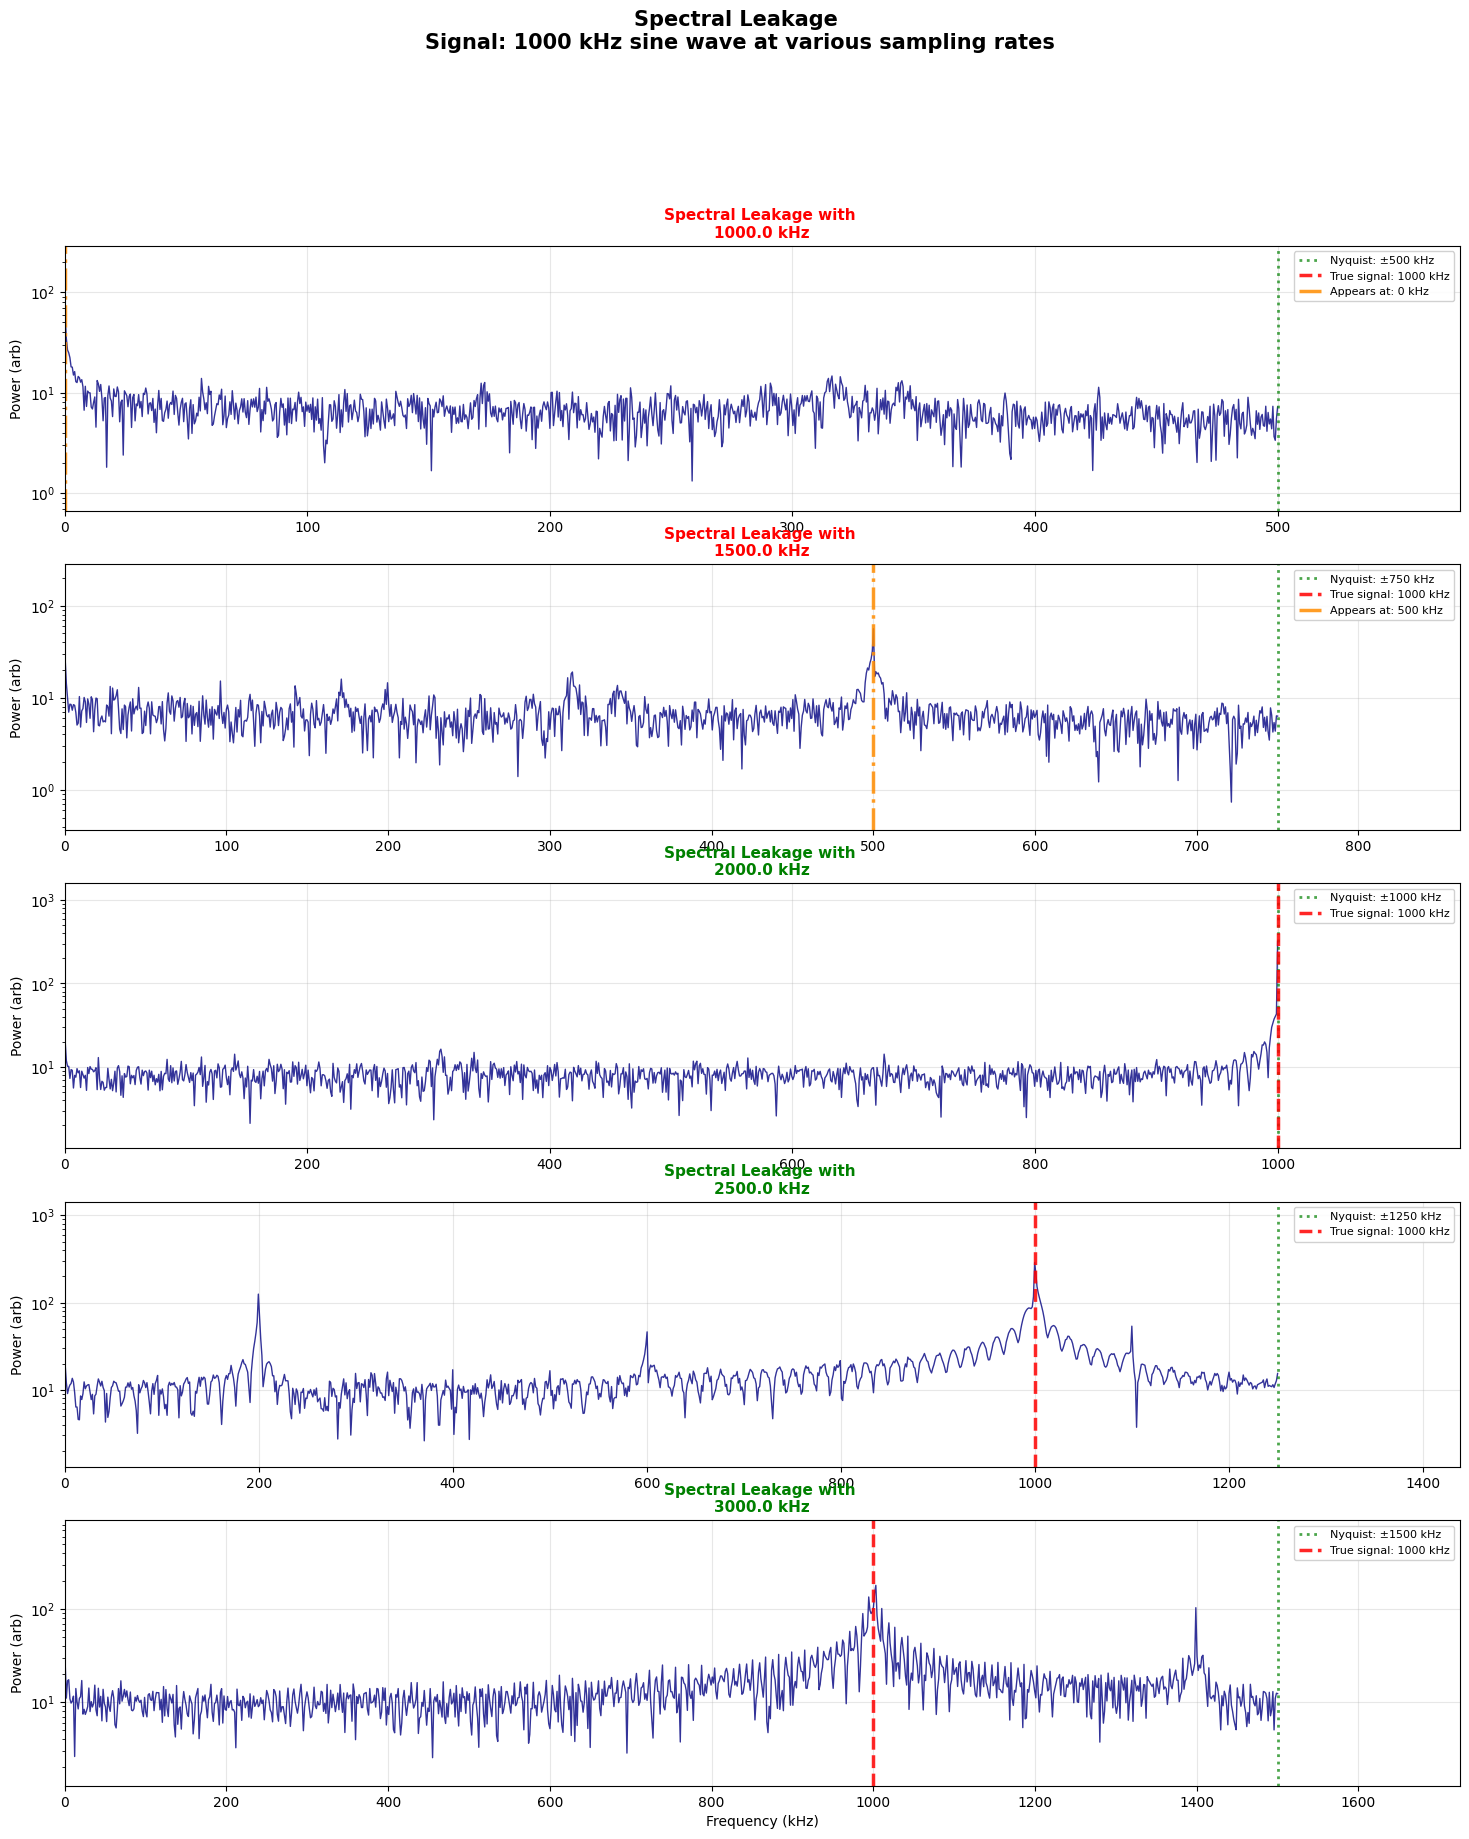

In [10]:
nyquist_files = [r"C:\Users\kaitl\radio_stars\Astro-121-Radio-Stars\lab1\sinewave_test\sine_wave_1e6_rf\bypassed_f1p000e06_sr1p000e06_20260205_002825.npz",
                 r"C:\Users\kaitl\radio_stars\Astro-121-Radio-Stars\lab1\sinewave_test\sine_wave_1e6_rf\bypassed_f1p000e06_sr1p500e06_20260205_002827.npz",
                 r"C:\Users\kaitl\radio_stars\Astro-121-Radio-Stars\lab1\sinewave_test\sine_wave_1e6_rf\bypassed_f1p000e06_sr2p000e06_20260205_002829.npz",
                 r"C:\Users\kaitl\radio_stars\Astro-121-Radio-Stars\lab1\sinewave_test\sine_wave_1e6_rf\bypassed_f1p000e06_sr2p500e06_20260205_002831.npz",
                 r"C:\Users\kaitl\radio_stars\Astro-121-Radio-Stars\lab1\sinewave_test\sine_wave_1e6_rf\bypassed_f1p000e06_sr3p000e06_20260205_002832.npz",
                ]

nyquist_data = {}
for file in nyquist_files:
    loaded = np.load(file)

    sr = loaded['sample_rate']
    data = loaded['data']
    
    if data.ndim > 1:
        data = data.squeeze()  
        
    if data.ndim > 1:
        data = data[0]
    
    nyquist_data[file] = {
        'data': data,
        'signal_freq': loaded['signal_freq'],
        'sample_rate': sr
    }


n_datasets = len(nyquist_data)
fig = plt.figure(figsize=(18, 4*n_datasets))


for row_idx, (file, ds) in enumerate(nyquist_data.items()):
    # Extract data
    data = ds['data']
    signal_freq = ds['signal_freq']
    sr = ds['sample_rate']
    nyquist = sr / 2
    
    if data.ndim > 1:
        data = data.flatten()
    ax_spec = fig.add_subplot(n_datasets, 1, row_idx + 1)
    # Compute power spectrum
    try:
        freqs, power = analysis.compute_power_spectrum(data, sr, method='dft')
        
        # Find peak safely
        peak_idx = np.argmax(power)
        measured_freq = abs(freqs[peak_idx])
    except Exception as e:
        print(f"  ERROR: {e}")
        raise
    # Determine if aliasing occurs
    is_aliasing = signal_freq > nyquist
    if is_aliasing:
        aliased_freq = sr - signal_freq
        status = f"ALIASING: {signal_freq/1e3:.0f}→{aliased_freq/1e3:.0f} kHz"
        status_color = 'red'
    else:
        status = "No Aliasing (fs > 2f)"
        status_color = 'green'
    
#spectral leakage

    
    ax_spec.semilogy(freqs/1e3, power, linewidth=1, color='navy', alpha=0.8)
    
    
    # Draw boundaries
    ax_spec.axvline(nyquist/1e3, color='green', linestyle=':', 
                   linewidth=2, alpha=0.7, label=f'Nyquist: ±{nyquist/1e3:.0f} kHz')
    ax_spec.axvline(-nyquist/1e3, color='green', linestyle=':', 
                   linewidth=2, alpha=0.7)
    
    # Mark frequencies
    ax_spec.axvline(signal_freq/1e3, color='red', linestyle='--', 
                   linewidth=2.5, alpha=0.85,
                   label=f'True signal: {signal_freq/1e3:.0f} kHz')
    
    if is_aliasing:
        ax_spec.axvline(aliased_freq/1e3, color='darkorange', linestyle='-.', 
                       linewidth=2.5, alpha=0.85,
                       label=f'Appears at: {aliased_freq/1e3:.0f} kHz')
    
    ax_spec.set_ylabel('Power (arb)', fontsize=10)
    ax_spec.set_title(f'Spectral Leakage with \n{sr/1e3} kHz', 
                     fontsize=11, fontweight='bold', color=status_color)
    ax_spec.legend(loc='upper right', fontsize=8, framealpha=0.9)
    ax_spec.grid(True, alpha=0.3)
    ax_spec.set_xlim([0, sr/2/1e3*1.15])
    
    power_positive = power[power > 0]
    if len(power_positive) > 0:
        ax_spec.set_ylim([power_positive.min() * 0.5, power.max() * 5])
    
    if row_idx == n_datasets - 1:
        ax_spec.set_xlabel('Frequency (kHz)', fontsize=10)

fig.suptitle('Spectral Leakage \n'
             f'Signal: {signal_freq/1e3:.0f} kHz sine wave at various sampling rates', 
             fontsize=15, fontweight='bold', y=0.998)

plt.show()

Figure 1.5: Detailed view of the signal peaks at the sampling rates exhibiting spectral leakage. Peaks display wide "skirts" and smaller "skirts" near the noise floor. This occurs because the finite recording window captured a non-integer number of sine wave cycles. This would create discontinuity at the edges of the data block. The FFT interprets this discontinuity as broadband energy, which then causes the signal power to "leak" from the central frequency bin into bins next to it.

## Results and Interpretation

### Undersampling & Aliasing ($f_s < 2f$)
When the sampling rate was below the Nyquist limit ($2000 \text{ kHz}$), we observed aliasing. The high-frequency signal was folded back into a lower frequency.

**$f_s = 1.0 \text{ MHz}$:** The signal was sampled exactly once per cycle. The time-domain reconstruction appeared as a flat DC line or a slow toggle. The power spectrum confirmed this with a peak at **$0 \text{ Hz}$**, matching the theory: $|1000 - 1000| = 0 \text{ kHz}$.

**$f_s = 1.5 \text{ MHz}$:** The signal frequency ($1000 \text{ kHz}$) exceeded the Nyquist limit ($750 \text{ kHz}$). The spectrum showed a distinct alias peak at **$500 \text{ kHz}$**. This aligns perfectly with the folding equation: $|f_s - f_{signal}| = |1500 - 1000| = 500 \text{ kHz}$.

### Critical Sampling & Oversampling ($f_s \geq 2f$)

**$f_s = 2.0 \text{ MHz}$ (Critical Sampling):** We captured exactly two points per cycle. The linear interpolation resulted in a triangle wave appearance. While the frequency was identified correctly in the spectrum, the amplitude and phase information were precarious.

**$f_s = 2.5 \text{MHz}$ & $f_s = 3.0 \text{ MHz}$ (Oversampling):** With $f_s > 2f$, the time-domain waveform was faithfully reconstructed as a sine wave. The power spectrum showed a single clean peak at the true frequency ($1000 \text{ kHz}$) with no aliases.

### The Power Spectrum & Nyquist Zones
The power spectrum plots revealed the "Nyquist Zones" (colored backgrounds of the power spectra graphs in the right column of Figure 1).
In the 1st Zone, represented by the zones with the green background, frequencies from $0$ to $f_s/2$ are measured correctly. In the 2nd Nyquist Zone, indicated by a yellow background, frequencies from $f_s/2$ to $f_s$ mirror (alias) back into the 1st zone.
The experiment successfully demonstrated that undersampled signals in the "Yellow Zone" mathematically map onto specific "ghost" frequencies in the "Green Zone," confirming the folding mechanism of aliasing.

### Spectral Leakage and Frequency Resolution ($\Delta f$)
In the plots for $f_s = 2.5 \text{ MHz}$ and $3.0 \text{ MHz}$, the signal peak is not an infinitely thin line but has "skirts" and side-lobes. This is spectral leakage, caused by the finite recording time. Since the recording window did not capture an integer number of cycles, the waveform has a discontinuity at the edges. This represents "leaking" energy into adjacent frequency bins. The sharpness of the peak is limited by the finite observation time. The resolution is $\Delta f = f_s / N$. At higher sampling rates (like 3.0 MHz), if $N$ is constant, the frequency bins become wider, reducing our ability to resolve closely spaced frequencies.

# Experiment Two: Noise Statistics

## Objective
The objective of this experiment was to characterize the statistical properties of thermal noise. Specifically, we sought to verify Gaussianity. With Gaussianity, we wanted to test that the instantaneous voltage samples we collect would follow a normal distribution. 

## Experimental Setup and Analysis
We disconnected the signal generator and connected a standard noise generator to the SDR input. For our parameters, the sample rate was 1 MH while the  bandwidth was 16384 samples/block. For collection, we captured 16 contiguous blocks of data to allow for averaging analysis. To analyze the statistics of noise data, we perform a histogram analysis. In the histogram, we took all the voltage samples from the first data block, binned them by 50 bins, and then fit a Gaussian probability density function. 

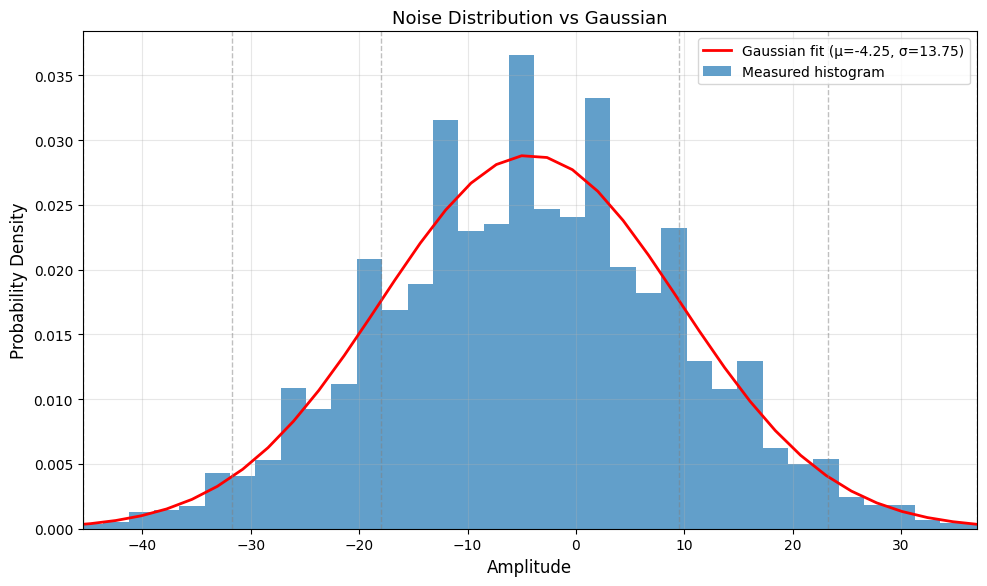

In [13]:
file = r"C:\Users\kaitl\radio_stars\Astro-121-Radio-Stars\lab1\noise_test\noise_1e6_sr\noise_sr1p000e06_1p600e01_samples1p638e04_20260204_234857.npz"

noise_file = np.load(file)
noise_data = noise_file['data']  # Shape: (16, 16384)


# Analyze one block
block0 = noise_data[0]
stats = analysis.analyze_noise_stats(block0)


mean = stats['mean']
std = stats['std']
valid_range = 1

mask = np.abs(block0 - mean) <= valid_range*std
data_filtered = block0[mask]


# Histogram vs Gaussian
hist, bin_centers, gaussian_fit = analysis.fit_gaussian(noise_data, bins=50)

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(bin_centers, hist, width=bin_centers[1]-bin_centers[0], 
       alpha=0.7, label='Measured histogram')
ax.plot(bin_centers, gaussian_fit, 'r-', linewidth=2, 
       label=f'Gaussian fit (μ={stats["mean"]:.2f}, σ={stats["std"]:.2f})')
ax.set_xlabel('Amplitude')
ax.set_ylabel('Probability Density')
ax.set_title('Noise Distribution vs Gaussian')
ax.set_xlim([mean - 3*std, mean + 3*std])
#ax.set_ylim([0, 1])

for n_sigma in [1, 2, 3]:
    ax.axvline(mean + n_sigma*std, color='gray', linestyle='--', linewidth=1, alpha = 0.5)
    ax.axvline(mean - n_sigma*std, color='gray', linestyle='--', linewidth=1, alpha =0.5)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Figure 3: Histogram of RF noise amplitudes measured by the SDR, overlaid with a theoretical Gaussian distribution (red line). The data closely follows the bell curve, verifying that the noise source is thermal and random in nature. However, the plot reveals hardware limitations: a DC offset shifts the center to μ≈−4.25, and the "comb-like" gaps between bars reveal the quantization errors caused by the discrete integer steps of the 8-bit Analog-to-Digital Converter.

##  Results and Discussion

We analyzed a block of RF noise to verify the Central Limit Theorem, which predicts that thermal noise (random electron motion) follows a Normal (Gaussian) distribution.
We plotted a histogram of the noise amplitude and overlaid a theoretical Gaussian curve calculated using the data's mean ($\mu$) and standard deviation ($\sigma$). The theory is mostly supported as the measured historgram relatively follows the envelope of the red Gaussian fit line. The statistical bounds also respect the "68-95-99.7" empirical rule. However, there are outliers that extend beyond the $\pm 3\sigma$. This leads to experimental uncertainties revolving around these results. For one, the distribution is centered at $\mu \approx -4.25$ rather than $0$. This could indicate that there was a negative DC bias in the hardware itself. Also, there are noticeable gaps between bars in the measured histogram. An explanation for this could be that the histogram is revealing the discrete integer steps of the SDR's Analog-to-Digital Converter. 

# Experiment Three: Heterodyne Mixing

## Objective
For this experiment, we demonstrate the difference between Double Sideband (DSB) and Single Sideband (SSB) mixing. In heterodyne reception, an incoming Radio Frequency (RF) signal is multiplied by a Local Oscillator (LO) to shift it to a lower intermediate frequency.
If we use a "real" mixer (multiplying two real voltages), the positive and negative frequency components mirror each other, causing the Upper and Lower sidebands to overlap. This is known as Spectral Folding. However, by using a "complex" mixer (recording both In-phase $I$ and Quadrature $Q$ components), we can preserve the phase information required to distinguish positive frequencies from negative ones, effectively isolating the sidebands.

## Experiment Set Up and Analysis
We captured complex data ($I + jQ$) using the RTL-SDR. We had two signal wave generators act as the Radio Frequency and Local Oscillator. The Radio Frequency was set at 1.0 MHz, and the Local Oscillator was set at 750 kHz. For the DSB, we used a mixer and set the input power to 0 dBm. We digitally sampled the output by sampling the signals twice so that we capture both the real and imaginary components.

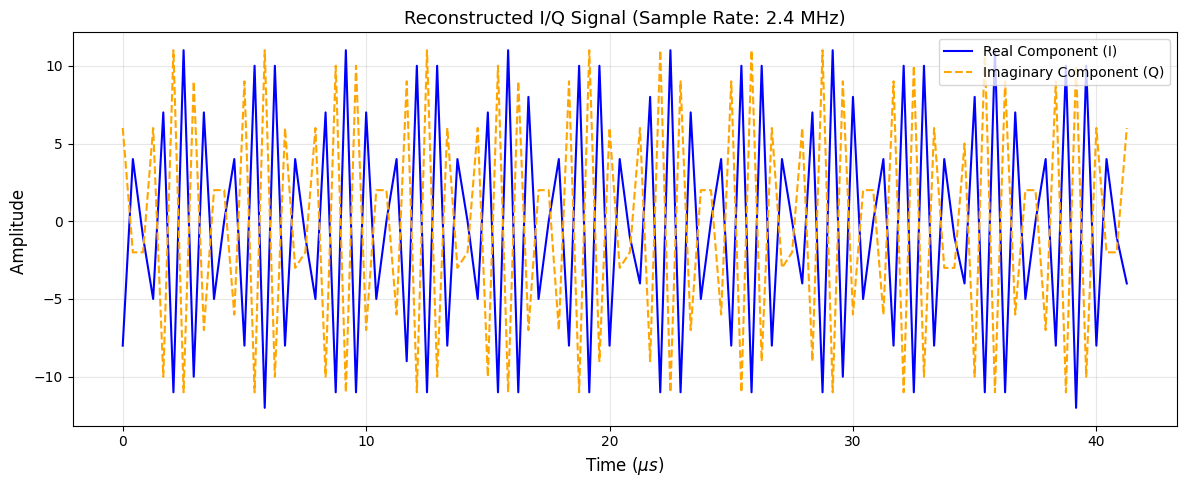

In [15]:
file_real = r"C:\Users\kaitl\radio_stars\Astro-121-Radio-Stars\lab1\mixer_sr2p400e06_lo_freq1p000e08_samples1p638e04_20260206_013825.npz"
file_imag = r"C:\Users\kaitl\radio_stars\Astro-121-Radio-Stars\lab1\mixer_sr2p400e06_lo_freq1p000e08_samples1p638e04_20260206_014241.npz"

data_real = np.load(file_real)['data'].flatten()
data_imag = np.load(file_imag)['data'].flatten()
sr = np.load(file_real)['sample_rate']

t = np.arange(len(data_real)) / sr * 1e6

plt.figure(figsize=(12, 5))


plt.plot(t[:100], data_real[:100], 
         label='Real Component (I)', color='blue', linewidth=1.5)


plt.plot(t[:100], data_imag[:100], 
         label='Imaginary Component (Q)', color='orange', linestyle='--', linewidth=1.5)


plt.title(f"Reconstructed I/Q Signal (Sample Rate: {sr/1e6:.1f} MHz)")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Amplitude ")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

Figure 4: Time-domain reconstruction of a complex signal using separate Real (I) and Imaginary (Q) data captures. The plot displays two sine waves with a relative phase shift, visually demonstrating the structure of a complex analytic signal (I+iQ). Because the two components were recorded at different times rather than simultaneously, the specific phase difference shown here is arbitrary, but it successfully illustrates the necessity of two channels to capture phase information.

## Observations
As seen in the top panel (DSB), taking the Fourier transform of real data results in a symmetric spectrum. By manually combining the Real data from one capture with the data from a second capture (treating it as Imaginary), we reconstructed a complex signal plot. Every signal at $+f$ has a "ghost" image at $-f$. In a radio receiver, this would make it impossible to know if a signal was originally at $f_{LO} + f$ (Upper Sideband) or $f_{LO} - f$ (Lower Sideband). The bottom panel (SSB) utilizes the complex data. Here, the symmetry is broken. We can clearly see that the signal exists only on one side of the zero (LO) frequency. This confirms that complex sampling allows for the  separation of the Upper and Lower sidebands. This prevents the spectral leakage or aliasing inherent in real-valued mixing. While this visualizes the concept of a complex analytic signal ($e^{i\omega t} = I + iQ$), the exact phase relationship is arbitrary because the two files were not recorded simultaneously.

However, there are a lot of experimental uncertainties. For one, our captured files showed only a "Real" (I) component with no corresponding "Imaginary" (Q) component initially. This indicates the SDR was likely configured in "Direct Sampling" mode rather than "Quadrature Mode," resulting in the loss of phase directionality. Not to mention, our experiment was rushed as the time allotted was constrained heavily due to the lack of generators available and time delayed with understanding which cables to utilize. This uncertainty with setting up the experiment could have caused the ambiguity in the data collection, which in turn causes the ambiguity in the graph in Figure 3. 

# Conclusion
This lab set out to answer the question: "What are the mathematical and physical limitations when converting analog radio signals into digital data?" Through our three experiments, we identified the specific boundaries that define the quality of a digital signal: the speed limit (Nyquist Theorem), the sensitivity limit (noise statistics), and the structural limit (I/Q Mixing).

For the Nyquist experiment, we proved that the sampling rate acts as a strict "speed limit" for frequency measurement. Our data showed that violating the condition $f_s > 2f$ causes aliasing, where high-frequency signals fold into lower frequencies. This confirmed that accurate digital reconstruction is not possible without adequate sampling speed.
For the noise statistics experiment, we determined that the "floor" of our data is defined by thermal physics and hardware precision. The noise analysis confirmed that background RF energy follows a Gaussian distribution, consistent with the Central Limit Theorem. However, we also identified hardware-specific limitations, including DC offset (shifted mean) and quantization (limiting resolution), which degrades the purity of the digital signal.
The mixer experiment demonstrates that a single stream of data is insufficient to capture the full picture of a radio wave. By attempting to reconstruct a signal from separate captures, we highlighted the necessity of Quadrature (I/Q) Mixing. Without capturing both the In-Phase and Quadrature components simultaneously, phase information is lost, and the signal cannot be fully characterized.

Cohesively, these results establish the mathematical and physical limitations for radio astronomy. We must sample the signal within a certain frequency limit (Nyquist theorem), with sufficient bit-depth to reduce the noise floor (noise statistics), and using mathematical concepts involving complex numbers (mixing) to preserve phase.

# Acknowledgements
I want to thank my lab partners, Joseph Moreno, Kennedy Haynes, and Helena Insko, for their assistance with data collection. We utilized `numpy`, `matplotlib`, and the `ugradio` package for this analysis. I would also like to thank Professor Aaron Parsons for providing the `ugradio` package and feedback on progress reports of the lab. Additionally, I want to thank our TA, Ben, for assisting with understanding the concepts behind this lab. 